In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as trns
import torch
from captcha.image import ImageCaptcha
from random import randint,seed
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
char_list = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f' ,'g',
    'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
            ]

In [3]:
class CaptchaData(Dataset):
    def __init__(self, char_list, num=10000):
        # 字元串列
        self.char_list = char_list
        # 字元轉id
        self.char2index = {
            self.char_list[i]:i for i in range(len(self.char_list))
        }
        # 標籤串列
        self.label_list = []
        # 圖片串列
        self.img_list = []
        # 生成驗證碼數量
        self.num = num
        for i in tqdm(range(self.num)):
            chars = ''
            for i in range(4):
                chars += self.char_list[randint(0, 35)]
            image = ImageCaptcha().generate_image(chars)
            self.img_list.append(image)
            # 不區分大小寫
            self.label_list.append(chars)
            
    def __getitem__(self, index):
        # 透過index去除驗證碼和對應標籤
        chars = self.label_list[index]
        image = self.img_list[index].convert('L')
        # 將字元轉乘Tensor
        chars_tensor = self._numerical(chars)
        image_tensor = self._totensor(image)
        # 把標籤轉化為 One-Hot 編碼，以適應多標籤損失函數的輸入
        label = chars_tensor.long().unsqueeze(1)
        label_onehot = torch.zeros(4, 36)
        label_onehot.scatter_(1, label, 1)
        label = label_onehot.view(-1)

        return image_tensor, label
    
    def _numerical(self, chars):
        # 標籤字元轉id
        chars_tensor = torch.zeros(4)
        for i in range(len(chars)):
            chars_tensor[i] = self.char2index[chars[i]]
        return chars_tensor
    
    def _totensor(self, image):
        # img to Tensor
        return trns.ToTensor()(image)
    
    def __len__(self):
        # 必須指定Dataset的長度
        return self.num

In [4]:
# 實例化一個 Dataset,大概要10,000個樣本才能訓練好的效果
data = CaptchaData(char_list, num = 10000)
dataloader = DataLoader(data, batch_size=128, shuffle=True)

val_data = CaptchaData(char_list, num=2000)
val_loader = DataLoader(val_data, batch_size=256, shuffle=True)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 265.87it/s]


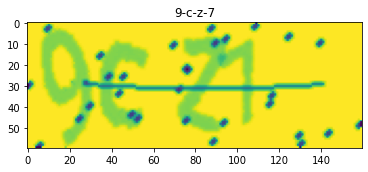

In [7]:
if __name__ == '__main__':
    img, label = data[10]
    predict = torch.argmax(label.view(-1, 36), dim=1)
    plt.title("-".join([char_list[lab.int()]for lab in predict]))
    plt.imshow(trns.ToPILImage()(img))
    plt.show()